<a href="https://colab.research.google.com/github/FranciscaAlliende/APS-Failure-at-Scania-Trucks/blob/master/SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [3]:
# setup
import matplotlib.pyplot as plt
import pandas as pd
from numpy import mean
import imblearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
# my libraries 
import basic_prepro as bp
import null_values as nv
import evaluation_metrics as em

In [4]:
# load data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_training_set.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/aps_failure_test_set.csv')

In [5]:
# basic prepocessing
# replace in class column: pos = 1; neg = 0
# replace the na and nan values with np.NaN
train = bp.data_prepro(train)
test = bp.data_prepro(test)

In [6]:
# null values
# drop the features with more than t% of null values on the train set 
# fill the remaining null values with the median of the corresponding feature with SimpleImputer(strategy = "median").
[y_train, X_train, y_test, X_test] = nv.null_values(train, test, t=0.5)

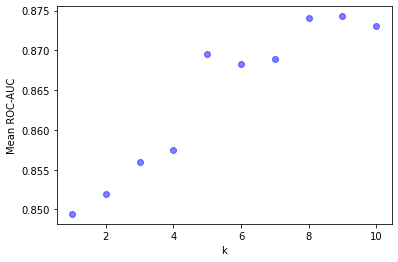

In [7]:
# choosing the number of neighbors k
k_values = range(1,11)
scores_list = []

for k in k_values:
  model = DecisionTreeClassifier()
  over = SMOTE(sampling_strategy=0.6, k_neighbors=k)
  under = RandomUnderSampler(sampling_strategy=0.8)
  steps = [('over', over), ('under', under), ('model', model)]
  pipeline = Pipeline(steps=steps)
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  score = mean(scores)
  scores_list.append(score)

plt.scatter(k_values, scores_list, c="b", alpha=0.5)
plt.xlabel("k")
plt.ylabel("Mean ROC-AUC")
plt.show()

In [8]:
# Transform the training set
# oversample
k = 10
over = SMOTE(sampling_strategy=0.6, k_neighbors=k) 
X_res, y_res = over.fit_resample(X_train, y_train)
print("original")
print(y_train.value_counts())
print("after oversampling")
print(y_res.value_counts())
# undersampling
under = RandomUnderSampler(sampling_strategy=0.8)
X_train_up, y_train_up = under.fit_resample(X_res, y_res) 
print("after undersampling (final)")
print(y_train_up.value_counts())

original
0    59000
1     1000
Name: class, dtype: int64
after oversampling
0    59000
1    35400
Name: class, dtype: int64
after undersampling (final)
0    44250
1    35400
Name: class, dtype: int64


In [9]:
# check
print(X_train.shape)
print(X_train_up.shape)
print(y_train.shape)
print(y_train_up.shape)

(60000, 162)
(79650, 162)
(60000,)
(79650,)


False positives:  177
False negatives:  47
Total cost: 25270
Confusion matrix, without normalization


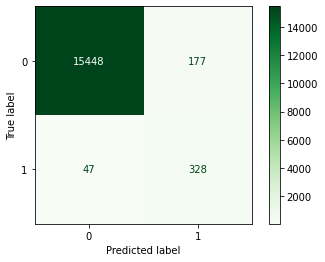

     Normalized confusion matrix


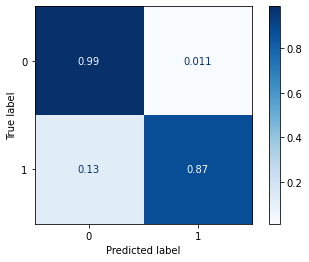

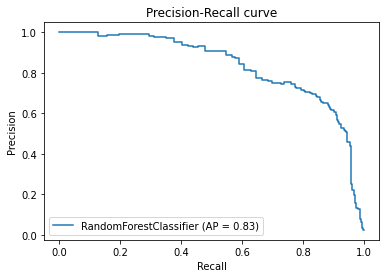

f1 score 0.745
precision:  0.65
recall 0.875


(25270, 0.7454545454545454, 0.6495049504950495, 0.8746666666666667)

In [10]:
# RF
clf_RF = RandomForestClassifier(random_state=333)
# training 
clf_RF.fit(X_train_up, y_train_up.values)
# prediction
y_pred_RF = clf_RF.predict(X_test)
# evaluation
em.evaluation_metrics(y_pred_RF, y_test, X_test, clf_RF, c1=10, c2=500)

False positives:  537
False negatives:  33
Total cost: 21870
Confusion matrix, without normalization


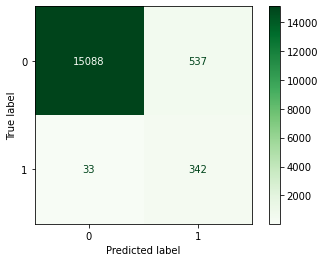

     Normalized confusion matrix


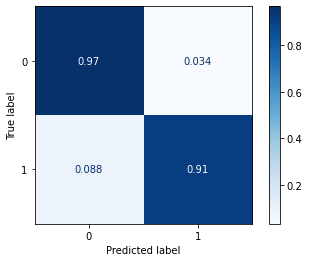

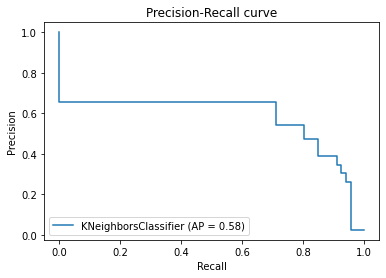

f1 score 0.545
precision:  0.389
recall 0.912


(21870, 0.5454545454545455, 0.3890784982935154, 0.912)

In [11]:
# k-NN
neigh = KNeighborsClassifier(n_neighbors=7)
# training 
neigh.fit(X_train_up, y_train_up.values)
# prediction
y_pred_neigh = neigh.predict(X_test)
# evaluation
em. evaluation_metrics(y_pred_neigh, y_test, X_test, neigh, c1=10, c2=500)

False positives:  629
False negatives:  27
Total cost: 19790
Confusion matrix, without normalization


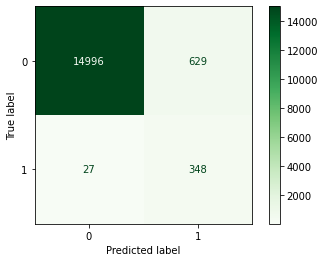

     Normalized confusion matrix


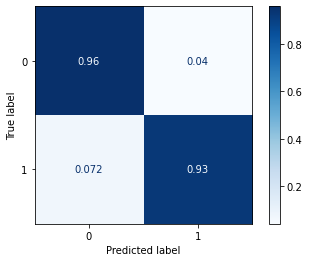

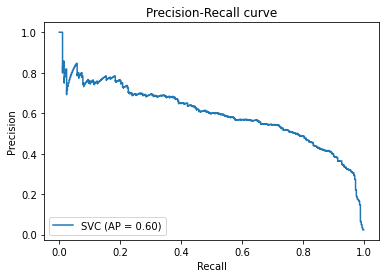

f1 score 0.515
precision:  0.356
recall 0.928


(19790, 0.514792899408284, 0.3561924257932446, 0.928)

In [14]:
# SVM
clf_SVM = svm.SVC()
# training 
clf_SVM.fit(X_train_up, y_train_up.values)
# prediction
y_pred_SVM = clf_SVM.predict(X_test)
# evaluation
em. evaluation_metrics(y_pred_SVM, y_test, X_test, clf_SVM, c1=10, c2=500)